# importing libraries....

In [89]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
import warnings
import random

In [86]:
# filter warnings...
warnings.filterwarnings("ignore")

# EDA

In [2]:
# getting the data
train = pd.read_csv("tweet-sentiment-extraction/train.csv")
test = pd.read_csv("tweet-sentiment-extraction/test.csv")
sub = pd.read_csv("tweet-sentiment-extraction/sample_submission.csv")
# train data head....
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
# test data head....
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [4]:
# submissive data...
sub.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [5]:
# train data shape
train.shape

(27481, 4)

In [6]:
# data info....
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
# looking for null values...
train.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [8]:
# as there is onyl single null value in training set, so it's better to drop it...
train.dropna(inplace=True)

In [9]:
# looking for null value in test set..
test.isna().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [10]:
# target label distribution....
sentiment = train["sentiment"].value_counts()
sentiment

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [11]:
# setting the plot style...
plt.style.use("ggplot")

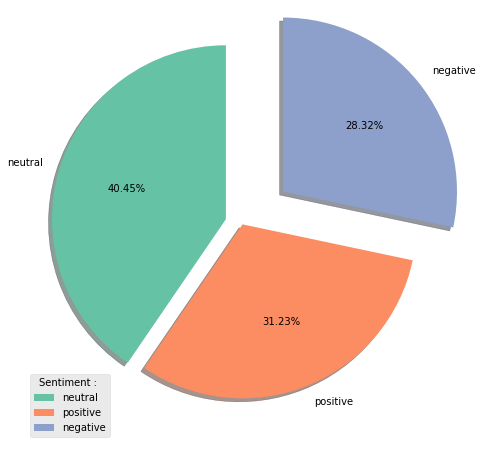

In [12]:
# plot the sentiment distribution...
plt.figure(figsize=(10,8))
labels = sentiment.index
colors = sns.color_palette("Set2")
explode = [0.1,0,0.3]
plt.pie(sentiment,labels = labels, colors = colors, explode = explode,
       autopct = "%.2f%%", startangle = 90, shadow = True)
plt.legend(title = "Sentiment : ")
plt.show()

In [13]:
# test data target label distribution
test_sentiment = test.sentiment.value_counts()
test_sentiment

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

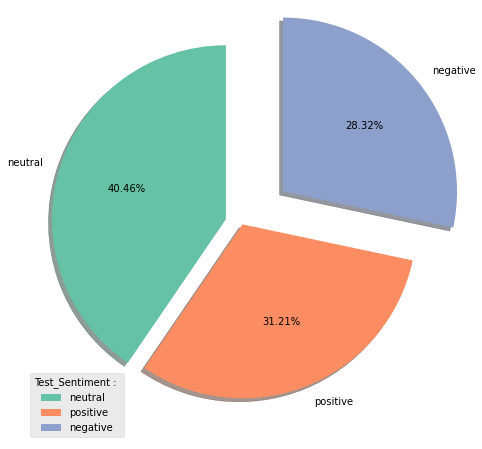

In [14]:
# plot the sentiment distribution...
plt.figure(figsize=(10,8))
labels = test_sentiment.index
colors = sns.color_palette("Set2")
explode = [0.1,0,0.3]
plt.pie(test_sentiment,labels = labels, colors = colors, explode = explode,
       autopct = "%.2f%%", startangle = 90, shadow = True)
plt.legend(title = "Test_Sentiment : ")
plt.show()

In [15]:
# changing the data-type...
train["text"] =  train["text"].astype("string")

In [16]:
# checking the length of the selected text...
train["length"] = train["text"].apply(lambda x: len(x.split()))
train.head()

,textID,text,selected_text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14


In [17]:
# checking the length of test text data
test["length"] = test["text"].apply(lambda x: len(x.split()))
test

,textID,text,sentiment,length
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,6
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,15
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,13
3,01082688c6,happy bday!,positive,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,5
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,15
3530,416863ce47,All alone in this old house again. Thanks for...,positive,26
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,18
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,14


In [18]:
print(f"Max length of tweet text in training set : {train['length'].max()}")
print(f"Min lenght of tweet text in training set. : {train['length'].min()}")
print(f"Max length of tweet text in test set : {test['length'].max()}")
print(f"Min lenght of tweet text in test set. : {test['length'].min()}")

Max length of tweet text in training set : 33
Min lenght of tweet text in training set. : 1
Max length of tweet text in test set : 32
Min lenght of tweet text in test set. : 1


In [19]:
print(f"Shortest tweets in training set : \n{train[train['length']==min(train['length'])]}")

Shortest tweets in training set : 
           textID           text selected_text sentiment  length
42     2e7082d1c8       MAYDAY?!      MAYDAY?!   neutral       1
68     fa2654e730       Chilliin      Chilliin  positive       1
127    8e1583cb08     Absolutely    Absolutely   neutral       1
224    f3a77c2b5e       _nesmith      _nesmith   neutral       1
238    e98226e842            Thx           Thx   neutral       1
...           ...            ...           ...       ...     ...
26690  e80c242d6a     Goodnight;    Goodnight;  positive       1
26693  7dc13f50d8   yessssssir!!  yessssssir!!   neutral       1
26726  aad244f37d          *hug*         *hug*  positive       1
26754  b6f6bd82c0       careless      careless  negative       1
26843  a46571fe12      congrats!     congrats!  positive       1

[199 rows x 5 columns]


In [20]:
print(f"longest tweets in training set : \n{train[train['length']==max(train['length'])]}")

longest tweets in training set : 
           textID                                               text  \
19887  ede80b9f63  AK, flop comes 2K6 I bet 15 get raised to 25 I...   
25359  be445111e7  : Lol it went okay! As far as I can tell . But...   

                                           selected_text sentiment  length  
19887  AK, flop comes 2K6 I bet 15 get raised to 25 I...   neutral      33  
25359                               Lol it went okay! As  positive      33  


<Figure size 720x576 with 0 Axes>

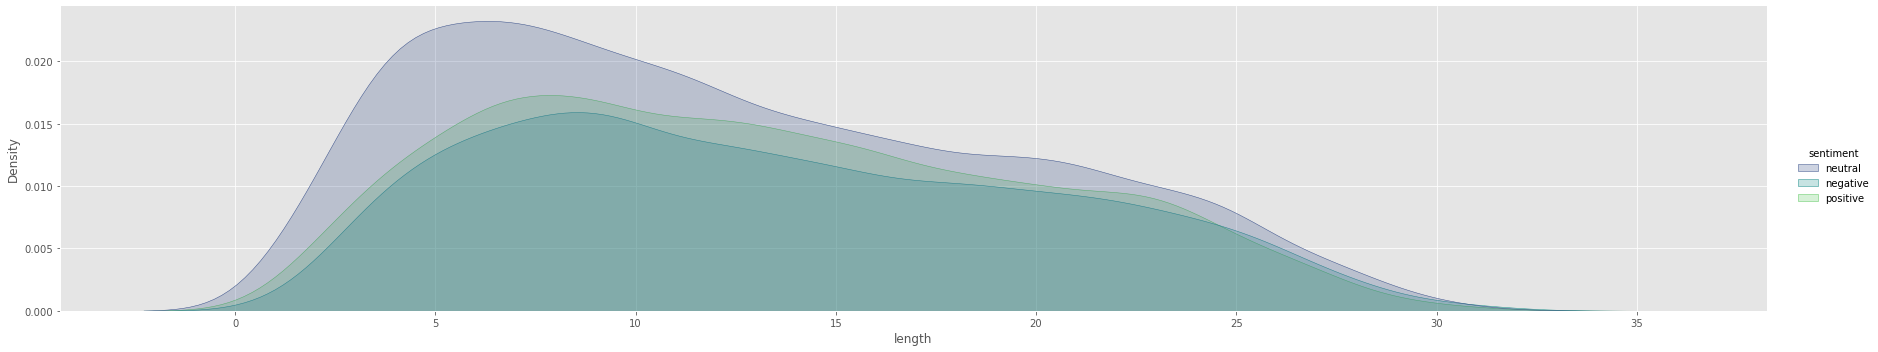

In [21]:
# plot the length of tweet text across the sentiment....
plt.figure(figsize=(10,8))
sns.displot(data = train, x = "length", hue = "sentiment",
           kind = "kde", fill = True, aspect = 5, palette = "viridis");

<Figure size 720x576 with 0 Axes>

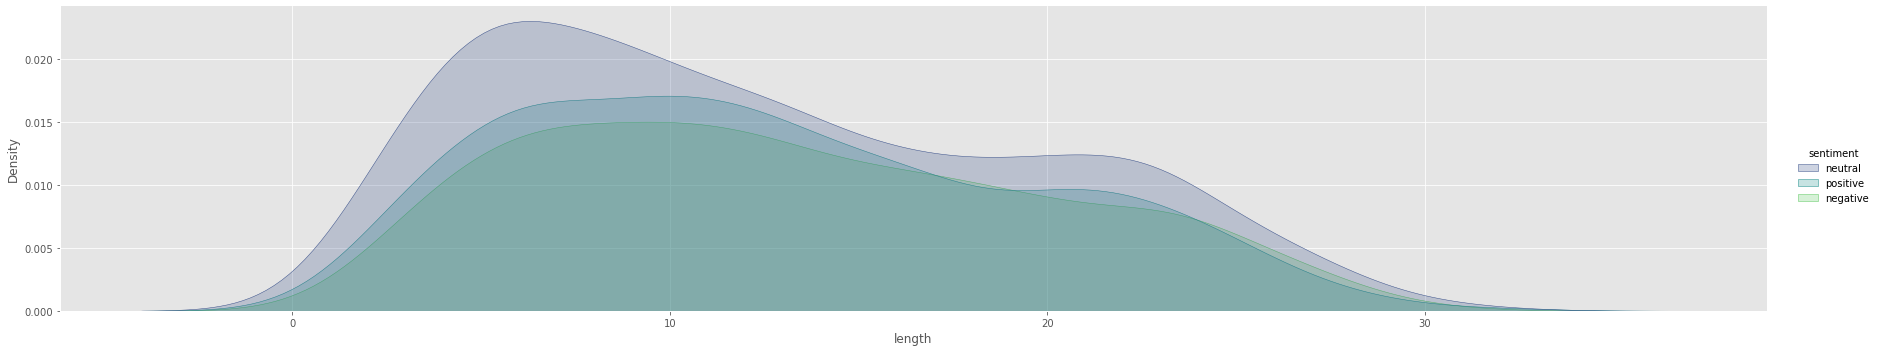

In [22]:
# plot the length of test tweet text across the sentiment....
plt.figure(figsize=(10,8))
sns.displot(data = test, x = "length", hue = "sentiment",
           kind = "kde", fill = True, aspect = 5, palette = "viridis");

In [23]:
# let's drop the selected_text column 
train.drop("selected_text",axis=1,inplace=True)

In [24]:
train.head(10)

,textID,text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,10
2,088c60f138,my boss is bullying me...,negative,5
3,9642c003ef,what interview! leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,14
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,neutral,12
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive,14
7,50e14c0bb8,Soooo high,neutral,2
8,e050245fbd,Both of you,neutral,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,positive,10


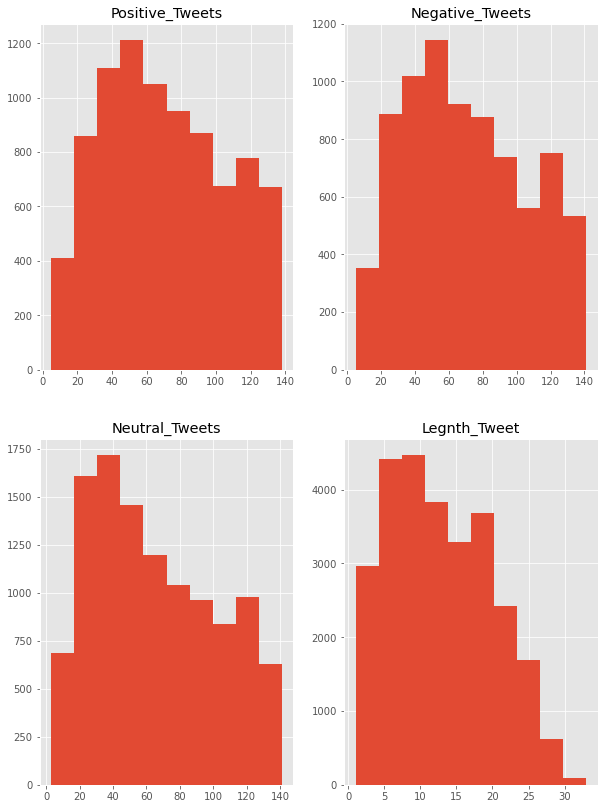

In [25]:
# plotting the number of characters in tweet per sentiment...

# positive tweet lenth
len_positive = train[train['sentiment']=="positive"]['text'].str.len()

# negative tweet length
len_negative = train[train["sentiment"]=="negative"]["text"].str.len()

# neutral tweet length
len_neutral = train[train["sentiment"]=="neutral"]["text"].str.len()

fig,ax = plt.subplots(2,2,figsize=(10,14))

# plotting positive tweet
ax[0,0].hist(len_positive)
ax[0,0].set_title("Positive_Tweets")

# plotting negative tweet
ax[0,1].hist(len_negative)
ax[0,1].set_title("Negative_Tweets")

# plotting positive tweet
ax[1,0].hist(len_neutral)
ax[1,0].set_title("Neutral_Tweets")

# plotting the overall length of tweets...
ax[1,1].hist(train["length"])
ax[1,1].set_title("Legnth_Tweet");

In [37]:
# now it's time to clean text, so let's make a function for it...
def clean_text(text):
    
    # convert text into lower
    text = str(text).lower()
    
    #     remove urls
    text = re.sub(r"https:\S+"," ",text)
    
    #     remove punctuation
    text = re.sub(r"[^\w\s]","",text)
    
    #     remove mentions
    text = re.sub(r'@\w+', " ", text)
    
    #     remove hashtags
    text = re.sub("#\w+"," ", text)
    
    #     remove digits
    text = re.sub(r"\d+"," ", text)
    
    #     remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
        
    return text 


In [38]:
# apply the function to train df
train["clean_text"] = train["text"].apply(lambda x : clean_text(x))

train.sample(10)

,textID,text,sentiment,length,clean_text
9915,233197e487,Is now crying Omg I am fed up with this pain !!!,negative,12,is now crying omg i am fed up with this pain
55,e77fd45003,I`d rather do the early run..but I am a morni...,neutral,11,id rather do the early runbut i am a morning ...
22533,7cf8a555d9,happppppyyyy mothersdayyyyyyyyy mummy you are...,positive,7,happppppyyyy mothersdayyyyyyyyy mummy you are...
22881,4e88d602cc,not having your lights on concerns me! Lol! S...,neutral,10,not having your lights on concerns me lol sta...
7991,e1d16cfff4,My Dad told me music that has the power to he...,positive,18,my dad told me music that has the power to he...
2730,14121b5602,I am very bummed that there are no babydoll or...,neutral,24,i am very bummed that there are no babydoll or...
6159,9e05410237,Stayin over at dustins tonight... my car hates...,negative,9,stayin over at dustins tonight my car hates me
5474,13f981fa30,ohhh beautiful place. You on hols? Go steady ...,positive,11,ohhh beautiful place you on hols go steady on...
12522,f3a526931d,Saying goodbye to a good trusted friend today....,positive,21,saying goodbye to a good trusted friend today ...
18933,c829b69a74,needs shows before wednesay!!! oh well... come...,positive,22,needs shows before wednesay oh well come one c...


In [39]:
# apply it to test data as well
test["clean_text"] = test["text"].apply(lambda x : clean_text(x))

test.sample(10)

,textID,text,sentiment,length,clean_text
246,b9ec075666,bought three books!! yipee!! now who`s with m...,neutral,12,bought three books yipee now whos with me on ...
1328,07ae045cbe,that was delicious! lets have a walk sometime...,neutral,18,that was delicious lets have a walk sometimes...
1905,4e38efebc2,eating my roommate`s cereal. sorry bro,negative,6,eating my roommates cereal sorry bro
2399,9630a8a60e,need some Pizza...can`t get out of office,neutral,7,need some pizzacant get out of office
2328,8e48929733,ipod died today,negative,3,ipod died today
3449,73fd2537e6,_g1986 a price drop would be nice I want anot...,positive,15,_g a price drop would be nice i want another...
713,d7607b8133,i wear a lot of white http://tinyurl.com/dlbltg,negative,7,i wear a lot of white httptinyurlcomdlbltg
687,52fd9f56fb,is off to work ... still 'recovering' from an ...,positive,21,is off to work still recovering from an amazi...
985,2418966865,I won`t be getting any ROTF toys `till MUCH l...,neutral,17,i wont be getting any rotf toys till much lat...
3078,051025ff7f,you should not be wasting the may bank holida...,negative,24,you should not be wasting the may bank holida...


In [61]:
# setting stopwords
stop=set(stopwords.words('english'))

Text(0.5, 0.98, 'Common words in tweet text')

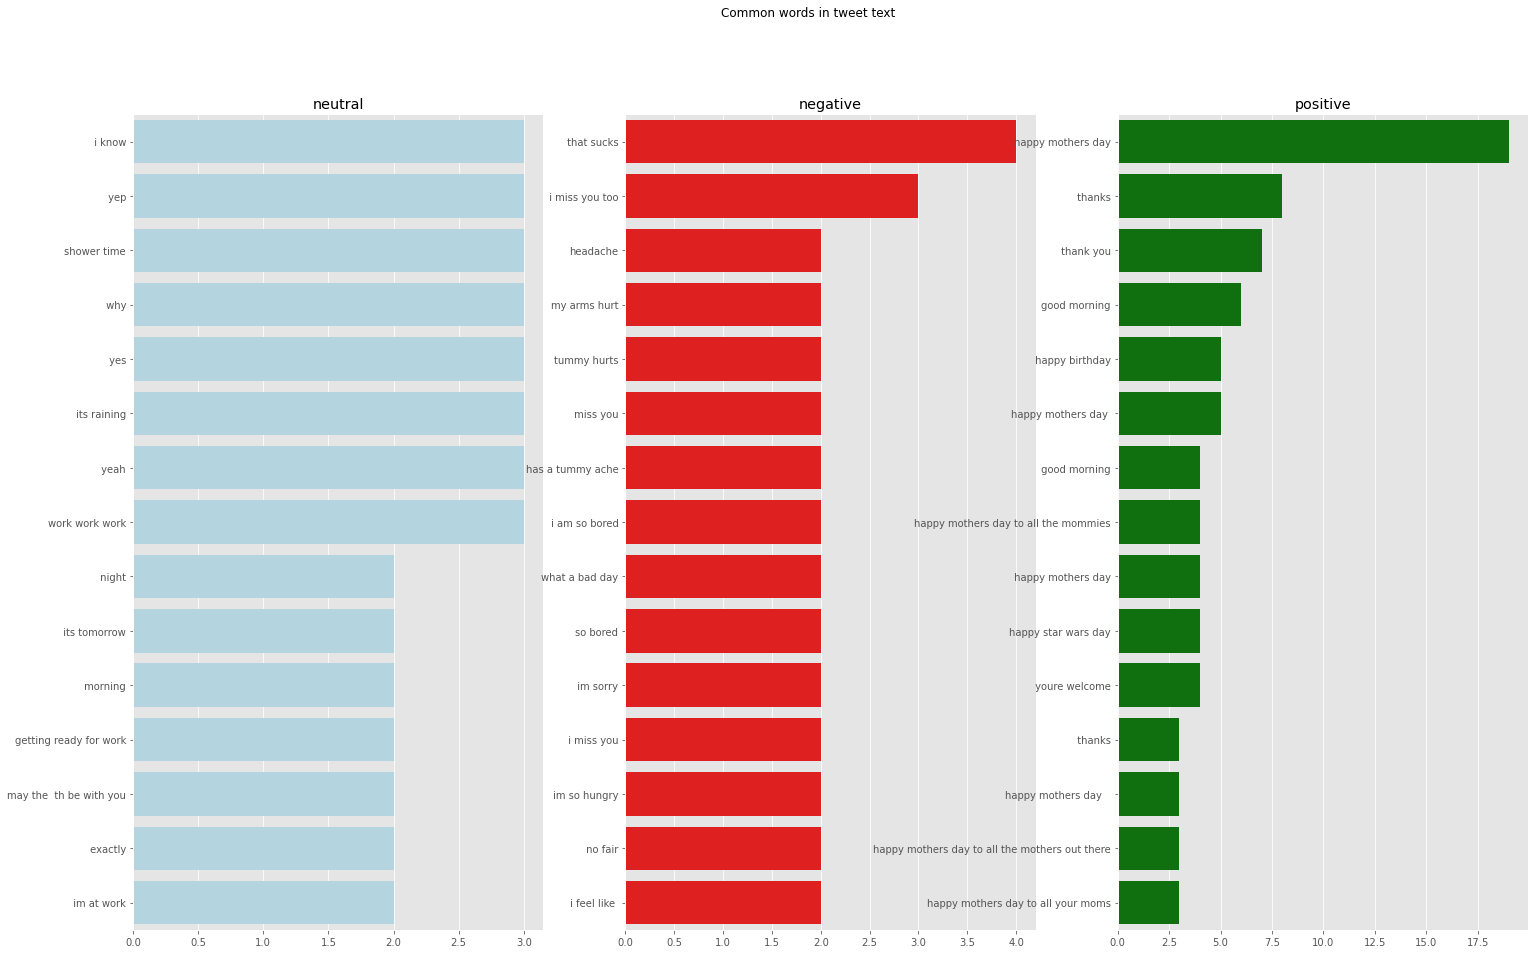

In [76]:
# let's find out the most common words in the text.....
sentiments = train["sentiment"].unique()

# setup the figure
fig,ax = plt.subplots(1,3, figsize=(25,15))
colors = ["lightblue","red","green",]
for i in range(3):
    new = train[train["sentiment"]==sentiments[i]]["clean_text"]
    counter = Counter(new)
    most_common = counter.most_common()
    if (word not in stop):
        x = []
        y = []
    
    for word,count in most_common[:15]:
        x.append(word)
        y.append(count)
        
    sns.barplot(x=y,y=x,ax=ax[i], color = colors[i])
    ax[i].set_title(sentiments[i])
fig.suptitle("Common words in tweet text")

In [77]:
# pick the main columns....
train_text = train["clean_text"]
train_labels = train["sentiment"]

test_text = test["clean_text"]
test_labels = test["sentiment"]

# Tokenization : 
    As we clean our text let's split the data and convert each split into integer through tokenization because our deep learning models works only with the numbers....



In [80]:
# find the average length of sentence...
round(np.mean(train["length"]))

13

In [87]:
# setup the vocabulary length...
max_token = 15000
max_len = 15


token = TextVectorization(max_tokens = max_token,
                         standardize = "lower_and_strip_punctuation",
                         output_mode = "int",
                         output_sequence_length = max_len,
                         split = "whitespace")

# adapt to text
token.adapt(train_text)

2022-10-12 23:07:11.026363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [88]:
# get some text information....
vocab = token.get_vocabulary()
print(f"Total words in the Vocabulary : {len(vocab)}")
print(f"Top five words in the Vocabulary : {vocab[:5]}")
print(f"Bottom five words in the Vocabulary : {vocab[-5:]}")

Total words in the Vocabulary : 15000
Top five words in the Vocabulary : ['', '[UNK]', 'i', 'to', 'the']
Bottom five words in the Vocabulary : ['rightards', 'rigby', 'rig', 'rieger', 'ridin']


In [104]:
# let's tokenize some sentence....
random_index = np.random.randint(0,len(train_text))
random_sentence = train_text[random_index]

print(f"Original Text : {random_sentence}\n")
print(f"Tokenize Sentence : {token([random_sentence])}")

Original Text :  went to wingstop without me

Tokenize Sentence : [[ 220    3 7012  370   16    0    0    0    0    0    0    0    0    0
     0]]


# Embedding
   
  A word embedding is a class of approaches for representing words and documents using a dense vector representation. Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn

In [107]:
embedd = Embedding(input_dim = max_token,
                  output_dim = 256,
                   input_length = max_len,
                   embeddings_initializer = "uniform",
                  )